# Read

In [117]:
import pandas as pd
import matplotlib
import pprint
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math

In [118]:
def format_table_text(latex_text):
    new_str = latex_text 
    new_str = new_str.replace("data\_size","data")
    new_str = new_str.replace("data_size","data")
    new_str = new_str.replace("data","Data [Byte]")
    new_str = new_str.replace("duration","Duration [µs]")
    new_str = new_str.replace("mtu_size","mtu.")
    new_str = new_str.replace("mtu\_size","mtu.")
    new_str = new_str.replace("mtu.","MTU [Byte]")
    new_str = new_str.replace("pakets","Pakets")
    new_str = new_str.replace("type","Record-Mode")
    new_str = new_str.replace("request_type","Transfer-Approach")
    new_str = new_str.replace("conn_interval","ci.")    
    new_str = new_str.replace("conn\_interval","ci.")    
    new_str = new_str.replace("Connection-Interval","ci.")    
    new_str = new_str.replace("ci.","Connection-Interval-Length [ms]")
    return new_str


In [119]:
df_hci = pd.read_csv("HCI_Output.csv").drop("Unnamed: 0",axis=1)
#df_ota = pd.read_csv("OTA_Output.csv").drop("Unnamed: 0",axis=1)

df_hci['type'] = ['HCI']*len(df_hci.index.values)
#df_ota['type'] = ['OTA']*len(df_ota.index.values)

# print(df_hci.shape,df_ota.shape)
#df_all = df_hci.append(df_ota)
df_all = df_hci
df_all.sort_values("starting_time")
print(df_all.columns)
df_all.drop(["data"],inplace=True,axis=1)

request_naming = dict({"WRITE_COMMAND Req":"NOTIFY-Approach","WRITE_COMMAND Rcvd":"NOTIFY-Approach","READ Req":"READ-Approach"})
df_all.replace(request_naming,inplace=True)

Index(['request_type', 'starting_time', 'ending_time', 'duration', 'data_size',
       'mtu_size', 'conn_interval', 'data', 'read_requests', 'read_responses',
       'notifies', 'type'],
      dtype='object')


In [120]:
def create_str(length):
    standardOutput = "Data Size " + str(length)
    content = ""
    i = len(standardOutput)
    while i < length:
        content += chr(97+(i%26))
        i+=1
    return standardOutput+content

### Value column does not contain all chars of string => can't check validity by data

In [121]:

#df_all['expected_data'] = df_all['data_size'].apply(create_str)
#df_all['is_complete'] = df_all['expected_data'] == df_all['data']
#df_all = df_all[df_all['is_complete']]
#df_all.drop(["data","is_complete","expected_data"],inplace=True,axis=1)
#df_all.groupby(["data_size","mtu_size","conn_interval","request_type","type"]).count()

In [122]:
#pd.set_option('display.max_rows', df_all.shape[0]+1)
#df_all[["type","request_type","data","expected_data","is_complete"]]

In [123]:
pprint.pprint(set(list(df_all['mtu_size'].values)))

{32, 256, 64, 128, 33, 35, 65, 67, 129, 131, 23, 25}


In [124]:
df_all = df_all[df_all['request_type'].str.contains("READ")]

In [125]:
def calc_rec_pakets(row):
    overhead = 1 
    if "NOTIFY" in row['request_type']:
        overhead = 3
    return math.ceil(row["data_size"]/(row["mtu_size"]-overhead))
def check_valid(row):
    if "NOTIFY" in row['request_type']:
        return row["notifies"] >= row['expected_receiving_pakets'] and row["notifies"] < 2+ row['expected_receiving_pakets']
    else:
        return row["read_responses"] >= row['expected_receiving_pakets'] and row["read_responses"] < 2+row['expected_receiving_pakets']
df_all['expected_receiving_pakets'] = df_all.apply(calc_rec_pakets,axis=1)
df_all['is_valid'] = df_all.apply(check_valid,axis=1)
pprint.pprint(df_all[~df_all['is_valid']])

Empty DataFrame
Columns: [request_type, starting_time, ending_time, duration, data_size, mtu_size, conn_interval, read_requests, read_responses, notifies, type, expected_receiving_pakets, is_valid]
Index: []


<ipython-input-125-5fa86a59f483>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['expected_receiving_pakets'] = df_all.apply(calc_rec_pakets,axis=1)
<ipython-input-125-5fa86a59f483>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['is_valid'] = df_all.apply(check_valid,axis=1)


In [126]:
df_all = df_all[df_all['is_valid']]
df_all.drop(["read_requests","read_responses","notifies","expected_receiving_pakets","is_valid"],inplace=True,axis=1)
df_all['conn_interval'] = df_all['conn_interval'].apply(lambda x:x*1.25)
df_all.reset_index(inplace=True,drop=True)
df_all

,request_type,starting_time,ending_time,duration,data_size,mtu_size,conn_interval,type
0,READ-Approach,2021-05-25 16:39:08.578330,2021-05-25 16:39:08.664347,86017,20,23,45.0,HCI
1,READ-Approach,2021-05-25 16:39:09.805890,2021-05-25 16:39:09.879159,73269,20,23,45.0,HCI
2,READ-Approach,2021-05-25 16:39:10.924819,2021-05-25 16:39:11.003862,79043,20,23,45.0,HCI
3,READ-Approach,2021-05-25 16:39:17.253474,2021-05-25 16:39:17.393375,139901,32,23,45.0,HCI
4,READ-Approach,2021-05-25 16:39:18.134810,2021-05-25 16:39:18.293497,158687,32,23,45.0,HCI
...,...,...,...,...,...,...,...,...
389,READ-Approach,2021-06-12 11:36:16.706251,2021-06-12 11:36:19.523156,2816905,352,23,80.0,HCI
390,READ-Approach,2021-06-12 11:36:20.298927,2021-06-12 11:36:22.963405,2664478,352,23,80.0,HCI
391,READ-Approach,2021-06-12 11:36:28.766184,2021-06-12 11:36:31.523284,2757100,353,23,80.0,HCI
392,READ-Approach,2021-06-12 11:36:32.279335,2021-06-12 11:36:34.963099,2683764,353,23,80.0,HCI


In [127]:
text = df_all.drop(["request_type","starting_time","ending_time"],axis=1).to_latex(label="table:readallvalues",caption="Alle Messwerte des Read-Ansatz",longtable=True)
text = format_table_text(text)
with open("outputs/all_read_values.tex", "w") as text_file:
    text_file.write(text)

print("save following table:")
df_all.drop(["request_type","starting_time","ending_time"],axis=1)

save following table:


,duration,data_size,mtu_size,conn_interval,type
0,86017,20,23,45.0,HCI
1,73269,20,23,45.0,HCI
2,79043,20,23,45.0,HCI
3,139901,32,23,45.0,HCI
4,158687,32,23,45.0,HCI
...,...,...,...,...,...
389,2816905,352,23,80.0,HCI
390,2664478,352,23,80.0,HCI
391,2757100,353,23,80.0,HCI
392,2683764,353,23,80.0,HCI


## df_mtu

In [128]:
df_mtu_mtu_values = [23,25,32,33,35,64,65,67,128,129,131,256]
df_mtu_data_size_values = [128]
df_mtu_conn_interval_values = [64]
df_mtu_conn_interval_values = [1.25 * x for x in df_mtu_conn_interval_values]
df_mtu = df_all[df_all['mtu_size'].apply(lambda x: x in df_mtu_mtu_values)]
df_mtu = df_mtu[df_mtu['data_size'].apply(lambda x:x in df_mtu_data_size_values)]
df_mtu = df_mtu[df_mtu['conn_interval'].apply(lambda x:x in df_mtu_conn_interval_values)]

## df_interval

In [129]:
df_interval_mtu_values = [35]
df_interval_data_size_values = [128]
df_interval_conn_interval_values = [36,64,128,256,512,1024]
df_interval_conn_interval_values  = [1.25 * x for x in df_interval_conn_interval_values ]
df_interval = df_all[df_all['mtu_size'].apply(lambda x: x in df_interval_mtu_values)]
df_interval = df_interval[df_interval['data_size'].apply(lambda x:x in df_interval_data_size_values)]
df_interval = df_interval[df_interval['conn_interval'].apply(lambda x:x in df_interval_conn_interval_values)]

## df_data

In [130]:
df_data_mtu_values = [23]
df_data_data_size_values = [21,22,23,43,44,45,65,66,67,87,88,89,175,176,177,351,352,353]
df_data_conn_interval_values = [64]
df_data_conn_interval_values = [1.25 * x for x in df_data_conn_interval_values]

df_data = df_all[df_all['mtu_size'].apply(lambda x: x in df_data_mtu_values)]
df_data = df_data[df_data['data_size'].apply(lambda x:x in df_data_data_size_values)]
df_data = df_data[df_data['conn_interval'].apply(lambda x:x in df_data_conn_interval_values)]

## MTU 
#### Estimation

In [131]:
def paket_func(data_size,mtu_size):
    return math.ceil(data_size/(mtu_size-1))
df = pd.DataFrame()
df["MTU"] = df_mtu_mtu_values
df["Antwort Pakete nach Formel"] = df['MTU'].apply(lambda x:paket_func(128,x))
df["Verbindungsintervalle nach Formel"] = df["Antwort Pakete nach Formel"].apply(lambda x:x*2)
estimated_df = df.set_index("MTU").T
text = estimated_df.to_latex(label="table:estimatedreadpakets",caption="Erwartete Auswirkung der MTU Änderung")
with open("outputs/estimated_read_mtu_change_table.tex", "w") as text_file:
    text_file.write(text)
estimated_df

MTU,23,25,32,33,35,64,65,67,128,129,131,256
Antwort Pakete nach Formel,6,6,5,4,4,3,2,2,2,1,1,1
Verbindungsintervalle nach Formel,12,12,10,8,8,6,4,4,4,2,2,2


In [132]:
df = pd.DataFrame()
df["mtu"] = range(23,256)
df["pakets by formular"] = df['mtu'].apply(lambda x:paket_func(128,x))
df['connection intervals by formular'] = df['pakets by formular'].apply(lambda x:x*2)
pd.set_option('display.max_rows', df.shape[0])
df[["connection intervals by formular","mtu"]].groupby("connection intervals by formular").agg(["min","max"])


mtu     
                                  min  max
connection intervals by formular          
2                                 129  255
4                                  65  128
6                                  44   64
8                                  33   43
10                                 27   32
12                                 23   26

In [133]:
df_mtu = df_mtu[["mtu_size","duration"]].rename(dict({"duration":"measured duration"}),axis=1).groupby(["mtu_size"]).min().reset_index(drop=False)
df_mtu["expected pakets"] = df_mtu["mtu_size"].apply(lambda x:paket_func(df_mtu_data_size_values[0],x))
df_mtu["expected connection interval"] = df_mtu["expected pakets"] * 2
df_mtu["expected duration"] = df_mtu["expected connection interval"] * df_mtu_conn_interval_values[0] * 1_000
df_mtu["expected duration"] = df_mtu["expected duration"].apply(lambda x:int(x))
text = df_mtu.drop(["expected connection interval","expected pakets"],axis=1).to_latex(label="table:readdetailmtuchange",caption="Read-Ansatz MTU Variationen",index=False)
text = format_table_text(text)
with open("outputs/read_mtu_change_table.tex", "w") as text_file:
    text_file.write(text)
df_mtu.drop(["expected connection interval","expected pakets"],axis=1)

,mtu_size,measured duration,expected duration
0,23,895989,960000
1,25,926603,960000
2,32,757677,800000
3,33,732689,640000
4,35,568862,640000
5,64,451940,480000
6,65,437974,320000
7,67,253555,320000
8,128,277714,320000
9,129,245250,160000


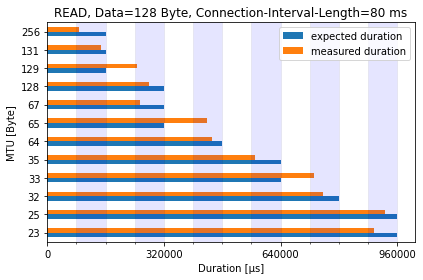

In [134]:
subplot = df_mtu.plot(x="mtu_size",y=["expected duration","measured duration"],kind="barh",xlabel="MTU")
step = int(df_mtu_conn_interval_values[0]*1_000)
if math.ceil(int(df_mtu['measured duration'].max())/step) <= 6:
    subplot.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(step))
elif math.ceil(int(df_mtu['measured duration'].max())/step) <= 10:
    subplot.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(step))
else:
    subplot.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(4*step))
subplot.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(step))
subplot.set_title("READ, Data=%d Byte, Connection-Interval-Length=%d ms"%(df_mtu_data_size_values[0],df_mtu_conn_interval_values[0]))
for i in range(step,int(df_mtu['measured duration'].max()),step*2):
    rect = patches.Rectangle((i, -10), step, 512, linewidth=0.5, edgecolor='black', facecolor='blue',alpha=0.1)
    subplot.add_patch(rect)
plt.xlabel("Duration [µs]")
plt.ylabel("MTU [Byte]")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig("outputs/read_mtu_change")

Die Grafik bestätigt die Formel xy mit drei Aussnahmen. Bei den Messwerten mit einer MTU von 33, 65 und 129 Byte, ist die Payload der Pakete ein ganzzahliger Teiler der zu übertragenden Daten, was bedeuetet die Größe jedes Pakets wird komplett ausgenutzt. Das bringt den Nachteil mit sich, dass der Client nach dem letzten Paket nicht weiß, ob es weitere Daten zum Übertragen gibt. Deshalb wird ein weiterer Request gesendet, der ohne Inhalt beantwortet wird. Daraus ergeben sich 2 weitere Intervalle. Unter berücksichtigung dieser Sonderfälle behält die Formel xy ihre Gültigkeit.

Insgesammt lässt sich sagen, dass man für bestimmte MTU Änderungen keine Verbesserungen in der Übertragungsdauer erzielen kann. Fasst man alle Werte zu MTU-Intervallen zusammen, kann man vorher sagen, um wie viel Byte die MTU vergrößert werden müsste, um eine verbesserung in der Übertragungsdauer zu erzielen. 


Mit Formel xy ergeben sich bei einer Daten-Größe von 128 Byte folgende Intervalle:  
$\text{Verbindungsintervalle}=\begin{cases}
2	& 129 < MTU <= 255 \\
4	& 65 < MTU <= 129 \\
6	& 44 < MTU <= 65 \\
8	& 33 < MTU <= 44 \\
10	& 27 < MTU <= 33 \\
12	& 23 < MTU <= 27 \\
\end{cases}$

Mit diesem Wissen, kann die Datengröße, oder die MTU verändert werden, um eine bessere Übertragungsdauer mit dem Read-Ansatz zu erzielen.
Allgemein zeigt sich, dass eine höhere MTU Größe zu einer kürzeren Übertragung durch weniger Pakete führt.

## Connection-Interval

,conn_interval,duration
0,45.0,351194
1,80.0,568862
2,160.0,1264949
3,320.0,2582054
4,640.0,3695220
5,1280.0,8961480


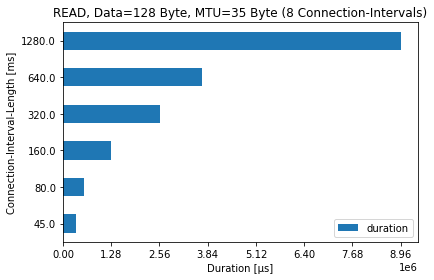

In [135]:
mtu = df_interval_mtu_values[0]
data = df_interval_data_size_values[0]
expected_conn_intervals = paket_func(data,mtu)*2
df_interval = df_interval[["conn_interval","duration"]].groupby(["conn_interval"]).min().reset_index(drop=False)
subplot = df_interval.plot(x="conn_interval",kind="barh",xlabel="Connection-Interval-Length [ms]")
subplot.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(df_interval_conn_interval_values[5]*1_000))
subplot.set_title("READ, Data=%d Byte, MTU=%d Byte (%d Connection-Intervals)"%(data,mtu,expected_conn_intervals))
plt.xlabel("Duration [µs]")
plt.tight_layout()
plt.savefig("outputs/read_connection_interval_change")
text = df_interval.to_latex(label="table:readdetailconnectionintervalchange",caption="Read-Ansatz Connection-Interval Variationen",index=False)
text = format_table_text(text)
with open("outputs/read_connection_interval_change_table.tex", "w") as text_file:
    text_file.write(text)
df_interval

Aus dieser Abbildung geht hervor, dass die Dauer der Übertragung direkt proportional von der Länge des Connection-Interval abhängt. Die Übertragung dauert bei halber Connection-Interval-Länge doppelt so lange als bei einfacher Länge.

## Data 

In [136]:
df_plot = df_data.drop(["starting_time","ending_time","mtu_size","conn_interval","type","request_type"],axis=1)
df_plot = df_plot.groupby("data_size").min().reset_index()
text = df_plot.to_latex(label="table:readdetaildatachange",caption="Read-Ansatz Datengröße Variationen",index=False)
text = format_table_text(text)
with open("outputs/read_data_change_table.tex", "w") as text_file:
    text_file.write(text)

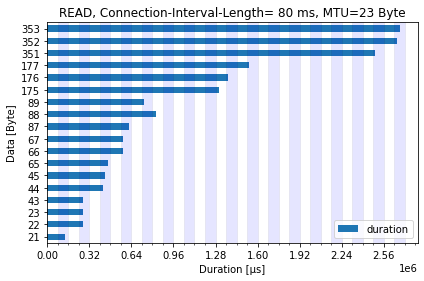

In [138]:
subplot = df_plot.plot("data_size","duration",kind="barh",xlabel="Data [Byte]")
step = int(64*1.25*1000)
for i in range(step,int(df_plot['duration'].max()),step*2):
    rect = patches.Rectangle((i, -10), step, 512, linewidth=0.5, edgecolor='black', facecolor='blue',alpha=0.1)
    subplot.add_patch(rect)
subplot.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(step*4))
subplot.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(step))
subplot.set_title("READ, Connection-Interval-Length=%d ms, MTU=%d Byte"%(64*1.25,23))
plt.tight_layout()
plt.xlabel("Duration [µs]")
plt.savefig("outputs/read_data_change")

Abbildung xy zeigt noch mal, dass bei Paketen die die Datenmenge ganzzahlig teilen (22,44,66,88,176,352) zwei Intervalle mehr benötigt werden, als Formel xx voraussagt. Aus den Aufzeichnungen lassen sich wieder Intervalle bestimmen, für welche Datenänderungen mit keinem Anstieg der Dauer zu rechnen ist.
Mit der Formel xx können die Intervalle bestimmt werden.

In [195]:
def paket_func_exact(data_size,mtu_size):
    return math.ceil(data_size/(mtu_size-1.1))
df = pd.DataFrame()
df["data_size"] = range(20,512)
df["pakets by formular"] = df['data_size'].apply(lambda x:paket_func_exact(x,23))
df['connection intervals by formular'] = df['pakets by formular'].apply(lambda x:x*2)
pd.set_option('display.max_rows', df.shape[0])
df[["connection intervals by formular","data_size"]].groupby("connection intervals by formular").agg(["min","max"])

data_size     
                                       min  max
connection intervals by formular               
2                                       20   21
4                                       22   43
6                                       44   65
8                                       66   87
10                                      88  109
12                                     110  131
14                                     132  153
16                                     154  175
18                                     176  197
20                                     198  219
22                                     220  240
24                                     241  262
26                                     263  284
28                                     285  306
30                                     307  328
32                                     329  350
34                                     351  372
36                                     373  394
38                                     395  416
40                                     417  438
42                                     439  459
44                                     460  481
46                                     482  503
48                                     504  511

Mit Formel xx ergeben sich bei einer MTU-Größe von 23 Byte folgende Intervalle:  
$\text{Verbindungsintervalle}=\begin{cases}
2 & 20 < Data <=21 \\
4 & 21 < Data <=43 \\
6 & 43 < Data <=65 \\
8 & 65 < Data <=87 \\
10 & 87 < Data <=109 \\
12 & 109 < Data <=131 \\
14 & 131 < Data <=153 \\
16 & 153 < Data <=175 \\
18 & 175 < Data <=197 \\
20 & 197 < Data <=219 \\
22 & 219 < Data <=240 \\
24 & 240 < Data <=262 \\
26 & 262 < Data <=284 \\
28 & 284 < Data <=306 \\
30 & 306 < Data <=328 \\
32 & 328 < Data <=350 \\
34 & 350 < Data <=372 \\
36 & 372 < Data <=394 \\
38 & 394 < Data <=416 \\
40 & 416 < Data <=438 \\
42 & 438 < Data <=459 \\
44 & 459 < Data <=481 \\
46 & 481 < Data <=503 \\
48 & 503 < Data <=511 \\
\end{cases}$